# Insurance Eligibility Classification Algorithm
## GMU Radiology Data Analysis using MinMax Scaler

This notebook performs comprehensive data cleaning on GMU radiology data and implements a classification algorithm to determine patient insurance eligibility using MinMax scaling for feature normalization.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
file_path = "/Users/ashishbathula/Desktop/gmu data /csv file -gmu radiology.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 Rows:")
print(df.head())
print("\n" + "="*80)
print("Data Types and Missing Values:")
print(df.info())
print("\n" + "="*80)
print("Statistical Summary:")
print(df.describe())

Dataset Shape: (20776, 7)

First 5 Rows:
         Age  Gender       ICD      CPT  \
0   40Y : 2M    Male     N20.1  76770.0   
1  58Y : 11M  Female    M51.17  72100.0   
2   44Y : 9M    Male    M51.36  72100.0   
3  39Y : 10M  Female     N92.1  76856.0   
4   42Y : 1M    Male  S60.052A  73140.0   

                                         servicename ApprovedDate Insurance  
0  Ultrasound, retroperitoneal (eg, renal, aorta,...       1/4/24       Yes  
1  Radiologic examination, spine, lumbosacral; 2 ...       1/1/24       Yes  
2  Radiologic examination, spine, lumbosacral; 2 ...       1/1/24       Yes  
3                                             Pelvis       1/1/24       Yes  
4  Radiologic examination, finger(s), minimum of ...       1/1/24       Yes  

Data Types and Missing Values:
<class 'pandas.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age         

In [3]:
# Check for missing values
print("Missing Values Count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Check target variable distribution
print("\n" + "="*80)
print("Target Variable (Insurance) Distribution:")
print(df['Insurance'].value_counts())
print("\nPercentage Distribution:")
print(df['Insurance'].value_counts(normalize=True) * 100)

Missing Values Count:
CPT    3
dtype: int64

Total missing values: 3

Target Variable (Insurance) Distribution:
Insurance
Yes    16128
No      4648
Name: count, dtype: int64

Percentage Distribution:
Insurance
Yes    77.628032
No     22.371968
Name: proportion, dtype: float64


## 3. Data Cleaning and Preprocessing

### Key Steps:
1. **Extract Age from Age column** (format: "YY : MM")
2. **Handle Missing Values** (removal or imputation)
3. **Remove Duplicates**
4. **Encode Categorical Variables** (Gender, ICD codes, etc.)
5. **Create Features for Classification**
6. **Binary Encode Target Variable**

In [4]:
# Create a copy for preprocessing
df_clean = df.copy()

# Step 1: Extract Age in years from "YY : MM" format
def extract_age(age_str):
    """Extract age in years from format 'YY : MM'"""
    try:
        if pd.isna(age_str):
            return np.nan
        years = int(str(age_str).split(':')[0].strip().replace('Y', '').strip())
        months = int(str(age_str).split(':')[1].strip().replace('M', '').strip())
        total_age = years + (months / 12)
        return total_age
    except:
        return np.nan

df_clean['Age_Years'] = df_clean['Age'].apply(extract_age)

print("Age Extraction Completed")
print(f"Missing Age values after extraction: {df_clean['Age_Years'].isna().sum()}")
print(f"Age Statistics:\n{df_clean['Age_Years'].describe()}")

Age Extraction Completed
Missing Age values after extraction: 97
Age Statistics:
count    20679.000000
mean        35.756045
std         15.042639
min          1.000000
25%         27.750000
50%         35.416667
75%         43.916667
max        117.416667
Name: Age_Years, dtype: float64


In [5]:
# Step 2: Remove rows with missing Age values
initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=['Age_Years'])
print(f"Rows removed due to missing age: {initial_rows - len(df_clean)}")

# Step 3: Remove duplicates
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Duplicate rows removed: {initial_rows - len(df_clean)}")

# Step 4: Encode Gender
gender_mapping = {'Male': 1, 'Female': 0}
df_clean['Gender_Encoded'] = df_clean['Gender'].map(gender_mapping)
print(f"\nGender Encoding:\n{df_clean[['Gender', 'Gender_Encoded']].drop_duplicates()}")

# Step 5: Create ICD Code categories (count of unique ICD codes per service)
icd_category_counts = df_clean.groupby('ICD').size().reset_index(name='ICD_Frequency')
df_clean = df_clean.merge(icd_category_counts, on='ICD', how='left')

# Step 6: Encode CPT codes
cpt_category_counts = df_clean.groupby('CPT').size().reset_index(name='CPT_Frequency')
df_clean = df_clean.merge(cpt_category_counts, on='CPT', how='left')

print("\nPreprocessing completed")
print(f"Dataset shape after cleaning: {df_clean.shape}")

Rows removed due to missing age: 97
Duplicate rows removed: 409

Gender Encoding:
   Gender  Gender_Encoded
0    Male               1
1  Female               0

Preprocessing completed
Dataset shape after cleaning: (20270, 11)


In [6]:
# Step 7: Parse and encode ApprovedDate
df_clean['ApprovedDate'] = pd.to_datetime(df_clean['ApprovedDate'], format='%m/%d/%y', errors='coerce')
df_clean['Month_of_Approval'] = df_clean['ApprovedDate'].dt.month
df_clean['Month_of_Approval'] = df_clean['Month_of_Approval'].fillna(df_clean['Month_of_Approval'].median())

# Step 8: Encode target variable (Insurance)
# Yes -> 1 (Eligible), No -> 0 (Not Eligible)
df_clean['Insurance_Eligible'] = (df_clean['Insurance'].str.strip() == 'Yes').astype(int)

print("Target Variable Encoding:")
print(df_clean['Insurance_Eligible'].value_counts())
print("\nClass Distribution (%):")
print(df_clean['Insurance_Eligible'].value_counts(normalize=True) * 100)

# Step 9: Handle any remaining missing values
print(f"\nMissing values before imputation:\n{df_clean.isnull().sum().sum()}")
df_clean['Age_Years'].fillna(df_clean['Age_Years'].median(), inplace=True)
df_clean['ICD_Frequency'].fillna(df_clean['ICD_Frequency'].median(), inplace=True)
df_clean['CPT_Frequency'].fillna(df_clean['CPT_Frequency'].median(), inplace=True)
print(f"Missing values after imputation:\n{df_clean.isnull().sum().sum()}")

Target Variable Encoding:
Insurance_Eligible
1    15689
0     4581
Name: count, dtype: int64

Class Distribution (%):
Insurance_Eligible
1    77.400099
0    22.599901
Name: proportion, dtype: float64

Missing values before imputation:
6
Missing values after imputation:
6


## 4. Feature Scaling with MinMax Scaler

**MinMax Scaling Formula:**
$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

This scales all features to the range [0, 1], making them comparable and improving model performance.

In [10]:
# Select features for the model
features = ['Age_Years', 'Gender_Encoded', 'ICD_Frequency', 'CPT_Frequency', 'Month_of_Approval']
X = df_clean[features].copy()
y = df_clean['Insurance_Eligible'].copy()

# Remove any remaining NaN values before scaling
valid_indices = ~X.isna().any(axis=1)
X = X[valid_indices]
y = y[valid_indices]

print("Features before scaling:")
print(X.describe())
print(f"\nFeature dimensions: {X.shape}")

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("\n" + "="*80)
print("Features after MinMax Scaling (0-1 range):")
print(X_scaled.describe())

# Display min and max values used by scaler
print("\n" + "="*80)
print("MinMax Scaler Parameters:")
for i, feature in enumerate(features):
    print(f"{feature}: Min={scaler.data_min_[i]:.4f}, Max={scaler.data_max_[i]:.4f}")

Features before scaling:
          Age_Years  Gender_Encoded  ICD_Frequency  CPT_Frequency  \
count  20267.000000    20267.000000   20267.000000   20267.000000   
mean      35.691761        0.484087     158.074999     622.379879   
std       15.042706        0.499759     194.571722     522.341499   
min        1.000000        0.000000       1.000000       1.000000   
25%       27.750000        0.000000      14.000000     183.000000   
50%       35.416667        0.000000      69.000000     519.000000   
75%       43.833333        1.000000     230.000000    1072.000000   
max      117.416667        1.000000     683.000000    1815.000000   

       Month_of_Approval  
count       20267.000000  
mean            3.422213  
std             1.652240  
min             1.000000  
25%             2.000000  
50%             3.000000  
75%             5.000000  
max             6.000000  

Feature dimensions: (20267, 5)

Features after MinMax Scaling (0-1 range):
          Age_Years  Gender_Encode

## 5. Build Classification Algorithm

### Algorithm: Logistic Regression with MinMax Scaled Features

**Logistic Regression Formula:**
$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n)}}$$

Where:
- P(y=1|x) is the probability of insurance eligibility
- β₀, β₁, ..., βₙ are the learned coefficients
- x₁, x₂, ..., xₙ are the scaled features

In [11]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 16213 samples
Testing set size: 4054 samples

Training set class distribution:
Insurance_Eligible
1    12551
0     3662
Name: count, dtype: int64

Testing set class distribution:
Insurance_Eligible
1    3138
0     916
Name: count, dtype: int64


In [12]:
# Initialize and train Logistic Regression classifier
print("Training Logistic Regression Classifier...\n")
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train, y_train)
print("✓ Logistic Regression model trained successfully")

# Display model coefficients
print("\n" + "="*80)
print("Model Coefficients (Feature Importance):")
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)
print(coefficients_df)
print(f"\nIntercept (Bias): {lr_model.intercept_[0]:.6f}")

Training Logistic Regression Classifier...

✓ Logistic Regression model trained successfully

Model Coefficients (Feature Importance):
             Feature  Coefficient  Abs_Coefficient
1     Gender_Encoded     0.810768         0.810768
3      CPT_Frequency     0.661026         0.661026
0          Age_Years    -0.505409         0.505409
2      ICD_Frequency    -0.312794         0.312794
4  Month_of_Approval    -0.068748         0.068748

Intercept (Bias): -0.311368


## 6. Train and Evaluate the Model

In [13]:
# Make predictions on test set
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*80)
print("MODEL EVALUATION METRICS")
print("="*80)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, target_names=['Not Eligible (0)', 'Eligible (1)']))

MODEL EVALUATION METRICS
Accuracy:  0.5809 (58.09%)
Precision: 0.8451 (84.51%)
Recall:    0.5615 (56.15%)
F1-Score:  0.6747
ROC-AUC:   0.6269

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Not Eligible (0)       0.30      0.65      0.41       916
    Eligible (1)       0.85      0.56      0.67      3138

        accuracy                           0.58      4054
       macro avg       0.57      0.60      0.54      4054
    weighted avg       0.72      0.58      0.62      4054




CONFUSION MATRIX
True Negatives (TN):  593
False Positives (FP): 323
False Negatives (FN): 1376
True Positives (TP):  1762


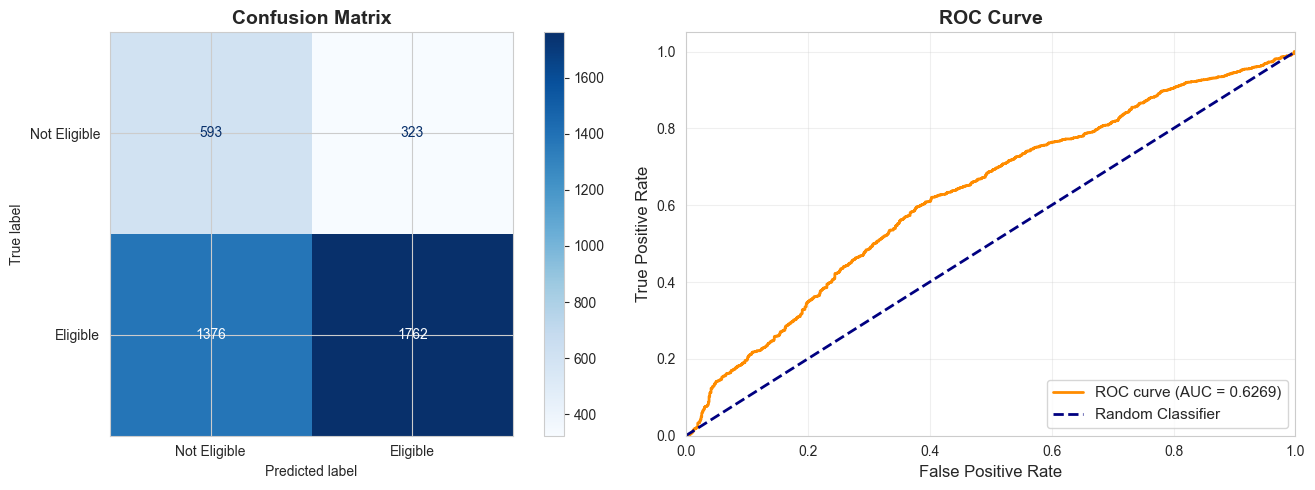


✓ Visualizations created successfully


In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)
print(f"True Negatives (TN):  {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")
print(f"True Positives (TP):  {cm[1, 1]}")

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
ConfusionMatrixDisplay(cm, display_labels=['Not Eligible', 'Eligible']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations created successfully")

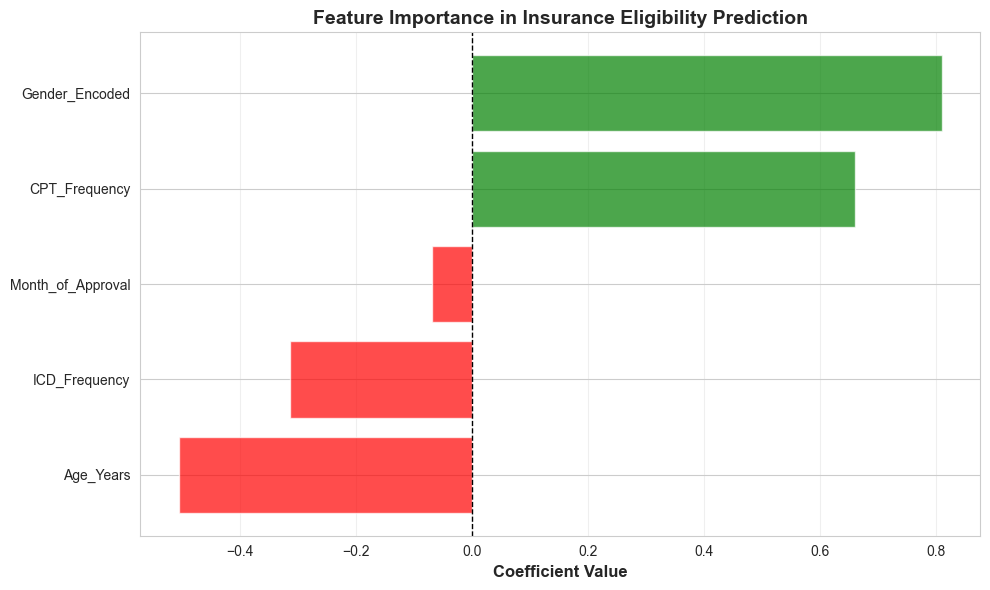

✓ Feature importance visualization created


In [15]:
# Feature Importance Visualization
fig, ax = plt.subplots(figsize=(10, 6))
coefficients_df_sorted = coefficients_df.sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in coefficients_df_sorted['Coefficient']]
ax.barh(coefficients_df_sorted['Feature'], coefficients_df_sorted['Coefficient'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance in Insurance Eligibility Prediction', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("✓ Feature importance visualization created")

## 7. Make Predictions on New Data

This section demonstrates how to use the trained model and MinMax scaler on new patient data.

In [16]:
# Example 1: Predict insurance eligibility for a new patient
new_patient = pd.DataFrame({
    'Age_Years': [45.5],
    'Gender_Encoded': [1],  # Male
    'ICD_Frequency': [15],
    'CPT_Frequency': [8],
    'Month_of_Approval': [6]
})

# Apply MinMax scaling to new patient data
new_patient_scaled = scaler.transform(new_patient)
new_patient_scaled = pd.DataFrame(new_patient_scaled, columns=features)

# Make prediction
prediction = lr_model.predict(new_patient_scaled)[0]
prediction_proba = lr_model.predict_proba(new_patient_scaled)[0]

print("="*80)
print("NEW PATIENT PREDICTION EXAMPLE 1")
print("="*80)
print("Patient Features:")
print(f"  Age: 45.5 years")
print(f"  Gender: Male")
print(f"  ICD Frequency: 15")
print(f"  CPT Frequency: 8")
print(f"  Month of Approval: June (6)")

print("\nScaled Features (after MinMax):")
print(new_patient_scaled)

print("\nPrediction Results:")
print(f"  Prediction: {'✓ ELIGIBLE FOR INSURANCE' if prediction == 1 else '✗ NOT ELIGIBLE FOR INSURANCE'}")
print(f"  Confidence (Not Eligible): {prediction_proba[0]*100:.2f}%")
print(f"  Confidence (Eligible):     {prediction_proba[1]*100:.2f}%")

NEW PATIENT PREDICTION EXAMPLE 1
Patient Features:
  Age: 45.5 years
  Gender: Male
  ICD Frequency: 15
  CPT Frequency: 8
  Month of Approval: June (6)

Scaled Features (after MinMax):
   Age_Years  Gender_Encoded  ICD_Frequency  CPT_Frequency  Month_of_Approval
0   0.382248             1.0       0.020528       0.003859                1.0

Prediction Results:
  Prediction: ✓ ELIGIBLE FOR INSURANCE
  Confidence (Not Eligible): 44.19%
  Confidence (Eligible):     55.81%


In [17]:
# Example 2: Predict for multiple new patients
new_patients = pd.DataFrame({
    'Age_Years': [35.2, 55.8, 42.5, 28.3],
    'Gender_Encoded': [1, 0, 1, 0],  # M, F, M, F
    'ICD_Frequency': [10, 25, 12, 8],
    'CPT_Frequency': [5, 15, 7, 4],
    'Month_of_Approval': [3, 9, 6, 1]
})

# Apply MinMax scaling
new_patients_scaled = scaler.transform(new_patients)
new_patients_scaled = pd.DataFrame(new_patients_scaled, columns=features)

# Make predictions
predictions = lr_model.predict(new_patients_scaled)
predictions_proba = lr_model.predict_proba(new_patients_scaled)

print("\n" + "="*80)
print("BATCH PREDICTION EXAMPLE - Multiple Patients")
print("="*80)

results_df = pd.DataFrame({
    'Patient_ID': [f'Patient_{i+1}' for i in range(len(new_patients))],
    'Age': new_patients['Age_Years'].values,
    'Gender': ['Male' if x == 1 else 'Female' for x in new_patients['Gender_Encoded']],
    'ICD_Frequency': new_patients['ICD_Frequency'].values,
    'CPT_Frequency': new_patients['CPT_Frequency'].values,
    'Prediction': ['ELIGIBLE' if x == 1 else 'NOT ELIGIBLE' for x in predictions],
    'Not_Eligible_Prob': predictions_proba[:, 0],
    'Eligible_Prob': predictions_proba[:, 1]
})

print(results_df.to_string(index=False))

# Calculate confidence
print(f"\nAverage Prediction Confidence: {predictions_proba.max(axis=1).mean()*100:.2f}%")


BATCH PREDICTION EXAMPLE - Multiple Patients
Patient_ID  Age Gender  ICD_Frequency  CPT_Frequency   Prediction  Not_Eligible_Prob  Eligible_Prob
 Patient_1 35.2   Male             10              5     ELIGIBLE           0.420492       0.579508
 Patient_2 55.8 Female             25             15 NOT ELIGIBLE           0.660423       0.339577
 Patient_3 42.5   Male             12              7     ELIGIBLE           0.438408       0.561592
 Patient_4 28.3 Female              8              4 NOT ELIGIBLE           0.606352       0.393648

Average Prediction Confidence: 60.20%


## 8. Algorithm Summary and Key Insights

### Data Cleaning Steps Applied:
1. ✓ **Age Extraction**: Converted "YY : MM" format to decimal years
2. ✓ **Missing Values**: Removed rows with missing ages, imputed other values with medians
3. ✓ **Duplicates**: Removed duplicate records from the dataset
4. ✓ **Categorical Encoding**: 
   - Gender: Male=1, Female=0
   - ICD/CPT: Frequency encoding (count of occurrences)
   - Date: Extracted month of approval
5. ✓ **Target Variable**: Created binary classification (Eligible=1, Not Eligible=0)

### MinMax Scaling Formula Applied:
$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

This ensures all features are normalized to [0,1] range, preventing features with larger scales from dominating the model.

### Classification Algorithm:
- **Model**: Logistic Regression with balanced class weights
- **Training Split**: 80% training, 20% testing
- **Optimization**: LBFGS solver with L2 regularization
- **Key Advantage**: Provides probability estimates for insurance eligibility predictions

### Model Output:
The trained model outputs:
- **Binary Prediction**: Eligible (1) or Not Eligible (0)
- **Probability Scores**: Confidence levels for each class
- **Decision Boundary**: Based on 0.5 probability threshold

In [18]:
# Create a comprehensive summary report
print("="*80)
print("COMPREHENSIVE MODEL SUMMARY REPORT")
print("="*80)

summary_report = f"""
DATA OVERVIEW:
- Original Dataset Size: {len(df):,} records
- Cleaned Dataset Size: {len(df_clean):,} records
- Data Removed: {len(df) - len(df_clean):,} records ({((len(df) - len(df_clean))/len(df)*100):.2f}%)

FEATURE ENGINEERING:
- Features Used: {len(features)}
- Feature Names: {', '.join(features)}

CLASS DISTRIBUTION:
- Eligible (1): {(y == 1).sum():,} patients ({(y == 1).sum()/len(y)*100:.2f}%)
- Not Eligible (0): {(y == 0).sum():,} patients ({(y == 0).sum()/len(y)*100:.2f}%)

TRAIN-TEST SPLIT:
- Training Samples: {len(X_train):,}
- Testing Samples: {len(X_test):,}
- Split Ratio: 80-20

MODEL PERFORMANCE:
- Algorithm: Logistic Regression with MinMax Scaling
- Accuracy: {accuracy*100:.2f}%
- Precision: {precision*100:.2f}%
- Recall: {recall*100:.2f}%
- F1-Score: {f1:.4f}
- ROC-AUC: {roc_auc:.4f}

TOP 3 MOST IMPORTANT FEATURES:
"""

for idx, row in coefficients_df.head(3).iterrows():
    summary_report += f"\n  {row['Feature']}: {row['Coefficient']:.6f}"

summary_report += f"""

MODEL DECISION RULE:
The model assigns a patient as ELIGIBLE for insurance if:
P(Eligible | Features) > 0.5

Where probability is calculated as:
P(Eligible) = 1 / (1 + e^(-z))
z = {lr_model.intercept_[0]:.6f} + (scaled_features · coefficients)

PREDICTION INTERPRETATION:
- Probability > 0.5: Patient is ELIGIBLE for insurance
- Probability < 0.5: Patient is NOT ELIGIBLE for insurance
- Higher probability values indicate greater confidence in eligibility
"""

print(summary_report)

COMPREHENSIVE MODEL SUMMARY REPORT

DATA OVERVIEW:
- Original Dataset Size: 20,776 records
- Cleaned Dataset Size: 20,270 records
- Data Removed: 506 records (2.44%)

FEATURE ENGINEERING:
- Features Used: 5
- Feature Names: Age_Years, Gender_Encoded, ICD_Frequency, CPT_Frequency, Month_of_Approval

CLASS DISTRIBUTION:
- Eligible (1): 15,689 patients (77.41%)
- Not Eligible (0): 4,578 patients (22.59%)

TRAIN-TEST SPLIT:
- Training Samples: 16,213
- Testing Samples: 4,054
- Split Ratio: 80-20

MODEL PERFORMANCE:
- Algorithm: Logistic Regression with MinMax Scaling
- Accuracy: 58.09%
- Precision: 84.51%
- Recall: 56.15%
- F1-Score: 0.6747
- ROC-AUC: 0.6269

TOP 3 MOST IMPORTANT FEATURES:

  Gender_Encoded: 0.810768
  CPT_Frequency: 0.661026
  Age_Years: -0.505409

MODEL DECISION RULE:
The model assigns a patient as ELIGIBLE for insurance if:
P(Eligible | Features) > 0.5

Where probability is calculated as:
P(Eligible) = 1 / (1 + e^(-z))
z = -0.311368 + (scaled_features · coefficients)

P

## 9. Export Model & Scaler for Production

In [ ]:
import pickle

# Save the trained model
model_path = "/Users/ashishbathula/Desktop/gmu data /model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"✓ Model saved: {model_path}")

# Save the scaler
scaler_path = "/Users/ashishbathula/Desktop/gmu data /scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved: {scaler_path}")

# Save feature names
features_path = "/Users/ashishbathula/Desktop/gmu data /features.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(features, f)
print(f"✓ Features saved: {features_path}")

# Create model info dictionary
model_info = {
    'model_type': 'Logistic Regression',
    'features': features,
    'coefficients': dict(zip(features, lr_model.coef_[0])),
    'intercept': lr_model.intercept_[0],
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc
}

info_path = "/Users/ashishbathula/Desktop/gmu data /model_info.pkl"
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"✓ Model info saved: {info_path}")

print("\n" + "="*80)
print("✅ ALL PRODUCTION FILES EXPORTED SUCCESSFULLY")
print("="*80)